In [1]:
# install py-sudoku library
!pip install py-sudoku

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# import library
from keras.models import load_model
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import numpy as np
import imutils
import cv2
from google.colab.patches import cv2_imshow
from keras.preprocessing.image import img_to_array
from sudoku import Sudoku
import time


In [10]:
# import model
model = load_model('/content/drive/MyDrive/Colab Notebooks/CSS496/model.h5')

In [11]:
# creat function for find a board
# Locates and extracts the board from image
def find_puzzle(image, debug=False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Gaussian blur 7*7 kernel
  blur = cv2.GaussianBlur(gray, (7, 7), 3)

  # Threshold
  thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)
  
  # Invert
  thresh = cv2.bitwise_not(thresh)

  # Check
  if debug:
    #cv2_imshow(gray)
    #cv2_imshow(blur)
    #cv2_imshow(thresh)
    cv2.waitKey(0)

  # Find contours in the thresholded image
  contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                          cv2.CHAIN_APPROX_SIMPLE)
  contour = imutils.grab_contours(contour)
  # Sort descending
  contour = sorted(contour, key=cv2.contourArea, reverse=True)

  # Initialize a contour that corresponds to the puzzle outline
  puzzleContour = None

  # Loop over the contours
  for c in contour:
		# Approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  
	  # If our approximated contour has four points, then we can
	  # assume we have found the outline of the puzzle
    if len(approx) == 4:
      puzzleContour = approx
      break

  # Exception
  if puzzleContour is None:
    raise Exception(("Could not find Sudoku puzzle outline.\n"
                      "Try debugging your thresholding and contour steps."))
  
  if debug:
		# draw the contour of the puzzle on the image and then display
		# it to our screen for visualization/debugging purposes
    output = image.copy()
    cv2.drawContours(output, [puzzleContour], -1, (0, 255, 0), 2)
    #cv2_imshow(output)
    cv2.waitKey(0)
  
  # Bird's eye view
  board_rgb = four_point_transform(image, puzzleContour.reshape(4, 2))
  board_gray = four_point_transform(gray, puzzleContour.reshape(4, 2))

  if debug:
    #cv2_imshow(board_rgb)
    #cv2_imshow(board_gray)
    cv2.waitKey(0)
  return (board_rgb, board_gray)

In [12]:
# create function for extract digit
def extract_digit(cell, debug=False):
  thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  thresh = clear_border(thresh)

  if debug:
    #cv2_imshow(thresh)
    cv2.waitKey(0)
  
  # Find contours
  contour = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contour = imutils.grab_contours(contour)

  # Empty cell
  if len(contour) == 0:
    return None
  
  # Otherwise, find the largest contour in the cell and create a
  # mask for the contour
  c = max(contour, key=cv2.contourArea)
  mask = np.zeros(thresh.shape, dtype="uint8")
  cv2.drawContours(mask, [c], -1, 255, -1)

  # Compute the percentage of masked pixels relative to the total
  # area of the image
  (height, width) = thresh.shape
  percentFilled = cv2.countNonZero(mask) / float(width * height)

	# If less than 3% of the mask, ignore the contour
  if percentFilled < 0.03:
    return None

	# Apply the mask
  digit = cv2.bitwise_and(thresh, thresh, mask=mask)
  digit2 = cv2.bitwise_and(thresh, thresh)
  digit3 = cv2.bitwise_and(thresh, mask)
  
  if debug:
    #cv2_imshow(cell)
    #cv2_imshow(digit)
    #cv2_imshow(digit2)
    #cv2_imshow(digit3)
    #cv2_imshow(thresh)
    #cv2.waitKey(0)
    return digit

In [13]:
def sudoku_solve (img_path):
  start = time.time()
  # Load image
  image = cv2.imread(img_path)
  image = imutils.resize(image, width=600)

  # Find puzzle
  (puzzleImage, warped) = find_puzzle(image, debug=True)

  # 9x9 board
  board = np.zeros((9, 9), dtype="int")

  # Infer the location of each cell
  stepX = warped.shape[1] // 9
  stepY = warped.shape[0] // 9

  # (x, y) - coordinates of each cell location
  cellLocation = []

  # Loop over the grid location
  for y in range(0, 9):
    row = []
    
    for x in range(0, 9):
      # (x, y)-coordinates of the current cell
      startX = x * stepX
      startY = y * stepY
      endX = (x + 1) * stepX
      endY = (y + 1) * stepY

      # Add the (x, y)-coordinates to our cell locations list
      row.append((startX, startY, endX, endY))

      # Extract the digit from the cell
      cell = warped[startY:endY, startX:endX]
      #cv2_imshow(cell)
      digit = extract_digit(cell, debug=True)

      # Not empty
      if digit is not None:
        # Resize to 50x50 pixels
        roi = cv2.resize(digit, (28, 28))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)

        # Prediction
        prediction = model.predict(roi).argmax(axis=1)[0]
        #print(prediction)
        board[y, x] = prediction
    # Add the row to cell locations
    cellLocation.append(row)

  # Construct a Sudoku puzzle from the board
  puzzle = Sudoku(3, 3, board=board.tolist())
  #puzzle.show()

  # Solve the Sudoku puzzle
  #print('Solving Sudoku puzzle...')
  solution = puzzle.solve()
  #solution.show_full()

  # loop over the cell locations and board
  for (cellRow, boardRow) in zip(cellLocation, solution.board):

    # loop over individual cell in the row
    for (box, digit) in zip(cellRow, boardRow):
      
      # unpack the cell coordinates
      startX, startY, endX, endY = box
      
      # Location to draw on image
      textX = int((endX - startX) * 0.33)
      textY = int((endY - startY) * -0.2)
      textX += startX
      textY += endY

      # Draw
      cv2.putText(puzzleImage, str(digit), (textX, textY), 
                  cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
      
  # Show outout image
  print('original image')
  cv2_imshow(image)
  print('sudoku solved ')
  cv2_imshow(puzzleImage)
  end = time.time()
  print('Time :',end-start, 'second')
  cv2.waitKey(0)

original image


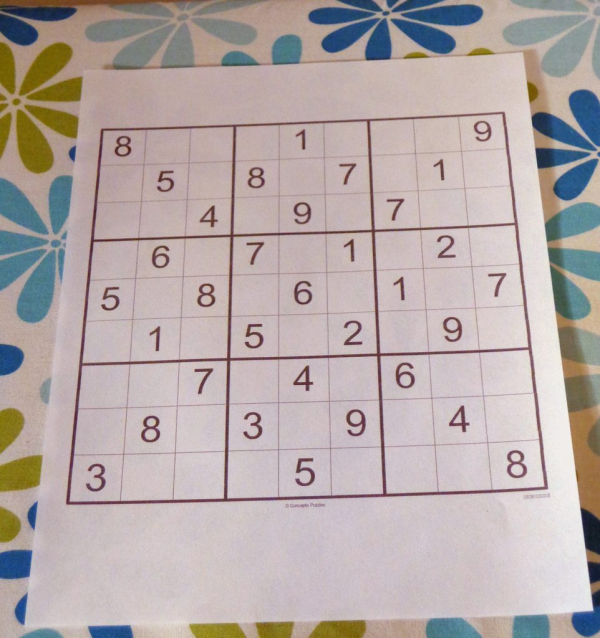

sudoku solved 


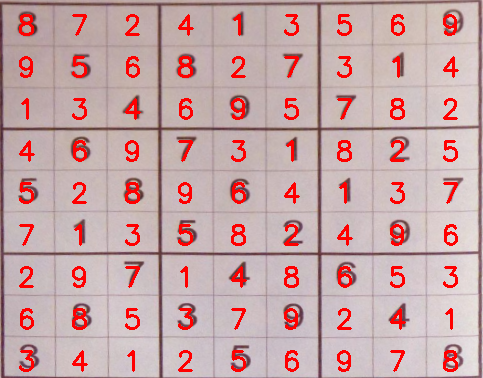

Time : 2.2175135612487793 second


In [14]:
sudoku_solve('/content/drive/MyDrive/Colab Notebooks/CSS496/puzzle/puzzle00.jpg')

original image


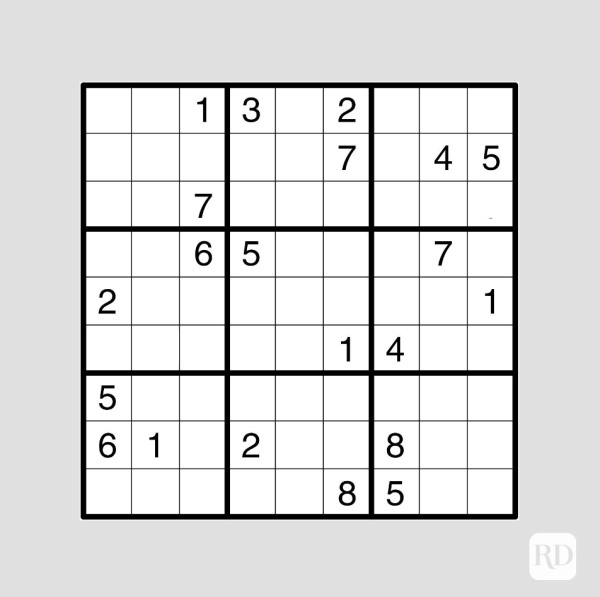

sudoku solved 


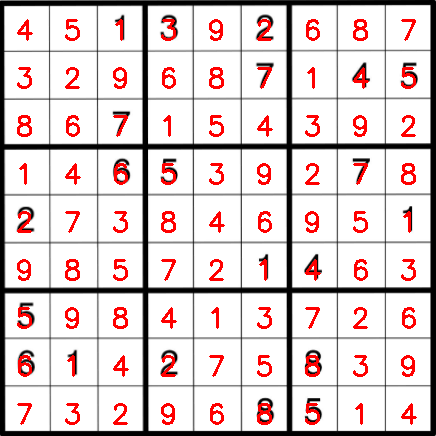

Time : 1.2292137145996094 second


In [15]:
sudoku_solve('/content/drive/MyDrive/Colab Notebooks/CSS496/puzzle/puzzle01.jpg')

original image


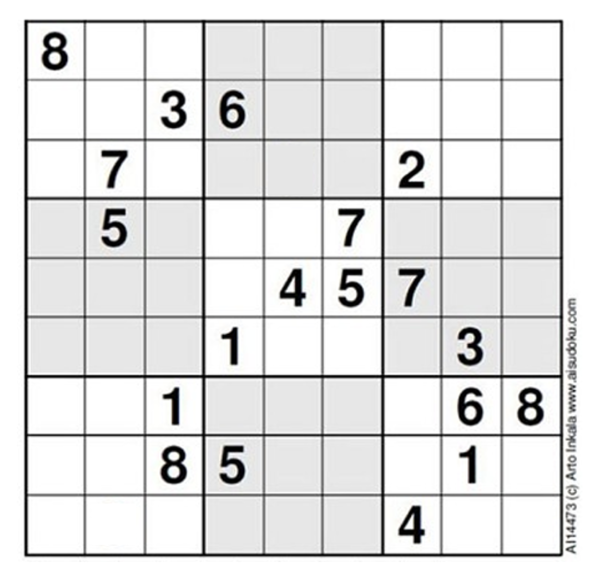

sudoku solved 


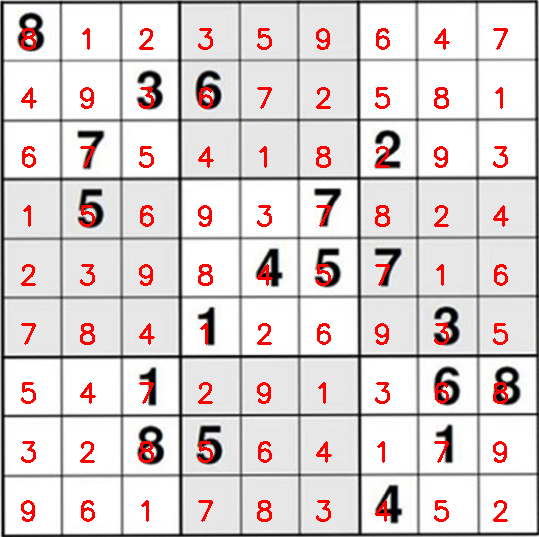

Time : 2.1066782474517822 second


In [16]:
sudoku_solve('/content/drive/MyDrive/Colab Notebooks/CSS496/puzzle/puzzle02.jpg')

Error: Command '['/content/deploy-sudokumodel-env/bin/python3', '-Im', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.
